In [1]:
import numpy as np
import random
import torch
import gym
import matplotlib.pyplot as plt
import copy

from tqdm.notebook import tqdm

In [2]:
class DQNAgent():
    def __init__(self):
        self.q_net = torch.nn.Sequential(*[
                                            torch.nn.Linear(4,64),
                                            torch.nn.Tanh(),
                                            torch.nn.Linear(64, 2),
                                           ])
        self.target_net = copy.deepcopy(self.q_net)
        
        self.replay_mem = []
        
        self.sync_freq_i = 0
        
        self.opt = torch.optim.Adam(self.q_net.parameters(), lr=0.01)
        
    def add_experience(self, s, a, r, ns):
        self.replay_mem.append((s, a, r, ns))
        self.replay_mem = self.replay_mem[-256:]
        
    def train(self):
        self.sync_freq_i += 1
        if self.sync_freq_i%5==0:
            self.target_net.load_state_dict(self.q_net.state_dict())

        batch = random.sample(self.replay_mem, 16)
        s_batch, a_batch, r_batch, ns_batch = [], [], [], []
        for t in batch:
            s, a, r, ns = t
            s_batch.append(s)
            a_batch.append(a)
            r_batch.append(r)
            ns_batch.append(ns)

        s_batch = torch.from_numpy(np.stack(s_batch)).float()
        a_batch = torch.from_numpy(np.stack(a_batch)).long()
        r_batch = torch.from_numpy(np.stack(r_batch)).float()
        ns_batch = torch.from_numpy(np.stack(ns_batch)).float()

        s_val = self.q_net(s_batch)
        s_val = s_val[torch.arange(len(a_batch)), a_batch]
        ns_val, ns_a = self.target_net(ns_batch).max(dim=-1)

        loss = (s_val - (r_batch+gamma*ns_val)).pow(2).mean()
        self.opt.zero_grad()
        loss.backward(retain_graph=True)
        self.opt.step()
        
    
    def get_action(self, state):
        Q, A = self.q_net(torch.from_numpy(state).float()[None, :])[0, :].max(dim=-1)
        return A.item()
        
agent = DQNAgent()

In [3]:
env = gym.make('CartPole-v0')

gamma = 0.95
epsilon = 1

train_actions = []
train_episode_len = []
train_epsilons = []

global_t = 0
for i_episode in range(1, 10000):
    s = env.reset()
    actions = []
    for t in range(200):
        global_t += 1
#         env.render()

        if np.random.uniform()<epsilon:
            a = env.action_space.sample()
        else:
            a = agent.get_action(s)
        actions.append(a)
        
        ns, r, done, info = env.step(a)
        
        agent.add_experience(s, a, r, ns)
        
        if global_t%128==0 and len(agent.replay_mem)>=256:
            for _ in range(4):
                agent.train()
        
        s = ns
        if done:
            break
            
    if epsilon>0.00 and len(agent.replay_mem)>=256:
#         epsilon = epsilon* .999
        epsilon -= (1/5000)
            
    if i_episode%250 == 0:
        print(i_episode)
        print(np.array(train_episode_len)[-250:].mean(), ' -------- eps: ',epsilon)
    
    train_actions.append(np.array(actions).mean())
    train_episode_len.append(t+1)
    train_epsilons.append(epsilon)
env.close()

250
22.309236947791163  -------- eps:  0.9524000000000052
500
22.844  -------- eps:  0.9024000000000107
750
23.38  -------- eps:  0.8524000000000163
1000
24.972  -------- eps:  0.8024000000000218
1250
24.864  -------- eps:  0.7524000000000273
1500
28.612  -------- eps:  0.7024000000000328
1750
27.32  -------- eps:  0.6524000000000383
2000
30.832  -------- eps:  0.6024000000000438
2250
34.516  -------- eps:  0.5524000000000493
2500
48.808  -------- eps:  0.5024000000000548
2750
58.268  -------- eps:  0.4524000000000603
3000
54.056  -------- eps:  0.4024000000000658
3250
18.748  -------- eps:  0.3524000000000713
3500
86.204  -------- eps:  0.30240000000007683
3750
54.964  -------- eps:  0.25240000000008234
4000
29.568  -------- eps:  0.20240000000008124
4250
32.04  -------- eps:  0.1524000000000798
4500
42.108  -------- eps:  0.10240000000007837
4750
72.544  -------- eps:  0.052400000000077294
5000
66.668  -------- eps:  0.0024000000000775016
5250
34.892  -------- eps:  -0.00019999999992

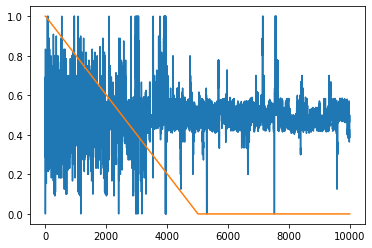

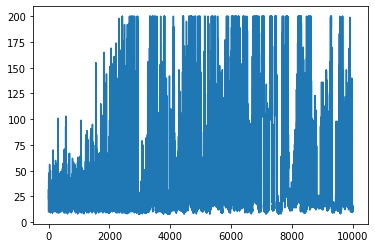

In [4]:
plt.plot(train_actions)
plt.plot(train_epsilons)
plt.show()
plt.plot(train_episode_len)
plt.show()

In [ ]:
print(env.action_space)
#> Discrete(2)
print(env.observation_space)
